## Introduction

### UMAP

* `n_neighbors`: This determines the number of neighboring points used in local approximations of manifold structure. Larger values will result in more global structure being preserved at the loss of detailed local structure. In general this parameter should often be in the **range 5 to 50**, with a choice of 10 to 15 being a sensible default.

* `min_dist`: This controls how tightly the embedding is allowed compress points together. **Larger values** ensure embedded points are **more evenly distributed**, while smaller values allow the algorithm to optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1 being a reasonable default.

* `metric`: This determines the choice of metric used to measure distance in the input space. A wide variety of metrics are already coded, and a user defined function can be passed as long as it has been JITd by numba.

`['euclidean','manhattan','chebyshev','minkowski','canberra','braycurtis','mahalanobis','wminkowski',,'cosine'，'correlation','haversine', 'hamming','jaccard','dice','russelrao', 'kulsinski', 'll_dirichlet', 'hellinger' ]`

euclidean
manhattan
chebyshev
minkowski
canberra
braycurtis
~~mahalanobis~~
wminkowski
~~seuclidean~~
cosine
correlation
haversine
hamming
jaccard
dice
~~russelrao~~
kulsinski
ll_dirichlet
hellinger
rogerstanimoto
sokalmichener
sokalsneath
yule

[UMAP API Guide](https://umap.scikit-tda.org/api.html)

* `n_components`: 2-3



### DBSCAN

`class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)`

* DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 

* Finds core samples of high density and expands clusters from them.

* Good for data which contains clusters of similar density.

`eps`

The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is **the most important DBSCAN parameter** to choose appropriately for your data set and distance function.

`min_samples`

The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

`metric`

The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by `sklearn.metrics.pairwise_distances` for its metric parameter.

* From scikit-learn: `['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']`.  These metrics support sparse matrix inputs. `['nan_euclidean']` but it does not yet support sparse matrices.

* `scipy.spatial.distance`:  `['braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']`

>  If metric is “precomputed”, X is assumed to be a distance matrix and must be square. X may be a Glossary, in which case only “nonzero” elements may be considered neighbors for DBSCAN.

`algorithm`
> The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors.
`{'auto', 'ball_tree', 'kd_tree', 'brute'}`

`leaf_size`, int, default=30

> Leaf size passed to BallTree or cKDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

In [1]:
# for everything else
import os
import random
# from random import randint
from functools import partial
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

# for loading/processing the images  
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
import pickle

import umap

# clustering and dimension reduction
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
# from sklearn.preprocessing import LabelEncoder
# from keras.utils.np_utils import to_categorical
from tqdm import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

from warnings import filterwarnings
filterwarnings('ignore')

#### Fixing random seeds for reproducibility


In [2]:
random.seed(10)
np.random.seed(10)

## Hyperparameters
* agglomerative: `n_clusters` `affinity`
* k-means: `n_initint`, `max_iter`

In [3]:
# metric = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
# algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

# dbscanparams = [[m,alg] for m in metric for alg in algorithm]
# dbscanparams, len(dbscanparams)

In [4]:
config = {
    'method': 'DBSCAN',
    'n_neighbors': range(20,200,20),
    'min_dist': np.arange(0.0, 1.2, 0.2),
    "umap_metric": ['manhattan','canberra','hellinger','correlation','cosine'],
    'n_components': 2,
    'eps': np.arange(0.5, 1.0, 0.05),
    'min_samples':np.arange(10, 30, 1),
    'dbscan_metric': ['l2'],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'n_init': 10,
    'max_evals': 2000,
    'random_state': 42
}

In [5]:
umap_space = len(config['n_neighbors']) * len(config['min_dist']) * len(config['umap_metric'])

hdbscan_space = len(config['eps']) * len(config['min_samples']) * len(config['dbscan_metric'] )

umap_space, hdbscan_space,  umap_space * hdbscan_space

(270, 200, 54000)

## Load Data

In [6]:
base_dir = '../input/nbiinfframes/FRAMES'
Fold1 = '../input/nbiinfframes/FRAMES/Fold1'
Fold2 = '../input/nbiinfframes/FRAMES/Fold2'
Fold3 = '../input/nbiinfframes/FRAMES/Fold3'

model_path = r'vgg16_weights_tf_dim_ordering_tf_kernels.h5'
pkl_file = r"../input/feature-embedding/files_feature_embeddings_vgg16.pkl"

class_ = ['B', 'I', 'S', 'U']
Folds = [Fold1, Fold2, Fold3]
all_data = []

# Define path to the data directory
for fold in Folds:
    for case in class_:
        path = os.path.join(fold, case)
        if os.path.isdir(path):
            for img in os.listdir(path):
                all_data.append([os.path.join(path, img), case, os.path.basename(fold)])
        
all_df = pd.DataFrame(all_data, columns=['image_path', 'class', 'folder'],index=None)
all_df.dropna(inplace = True)

#mapping the image name with the image path
all_df['name'] = all_df['image_path'].map(lambda x: os.path.basename(x))
img_name = all_df['name'] .to_list()
files = all_df['image_path'].to_list()

## Methods: Building Model

In [7]:
%%time

model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
out_features = model.output.shape[1] # to obtain the number of the output feature

print(out_features)

2022-04-26 00:54:36.743442: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


553476096/553467096 [==============================] - 8s 0us/step
4096
CPU times: user 3.96 s, sys: 3.44 s, total: 7.4 s
Wall time: 10.5 s


## Feature Extraction by CNN

In [8]:
def extract_features(files, model, pkl="", out_feature=out_features):
    
    data = {}
    if os.path.exists(pkl):
        with open(pkl, 'rb') as f:
            data = pickle.load(f)
    else:
        print("File data pkl file doesn't exist..., extracting by model")
        for file in files:
            resized_img = load_img(file, target_size=(224,224)) ##reshaped
            img_arr = np.array(resized_img) 
            reshaped_img = img_arr.reshape(1,224,224,3)  ##reshape
            imgx = preprocess_input(reshaped_img)
            embeddings = model.predict(imgx, use_multiprocessing=True)
            data[os.path.basename(file)] = embeddings
            
        pickle.dump(data, open(pkl, "wb"))

    filenames = np.array(list(data.keys()))
    feat = np.array(list(data.values()))
    feat = feat.reshape(-1, out_features)
        
    return filenames, feat

In [9]:
%%time

filenames, feat = extract_features(files, model, pkl_file, out_features)    
print('extracted feature shape: {}'.format(feat.shape))

extracted feature shape: (720, 4096)
CPU times: user 12.7 ms, sys: 10.8 ms, total: 23.5 ms
Wall time: 174 ms


## Optimal EPS

In [10]:
umap_embeddings = umap.UMAP(n_neighbors = 50,
                                min_dist = 0,
                                n_components = 2,
                                metric = 'manhattan',
                                random_state = config['random_state']).fit_transform(feat)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(umap_embeddings)
distances, indices = nbrs.kneighbors(umap_embeddings)
distances

array([[0.        , 0.11987423],
       [0.        , 0.09700253],
       [0.        , 0.04242638],
       ...,
       [0.        , 0.01417844],
       [0.        , 0.01412392],
       [0.        , 0.05732189]])

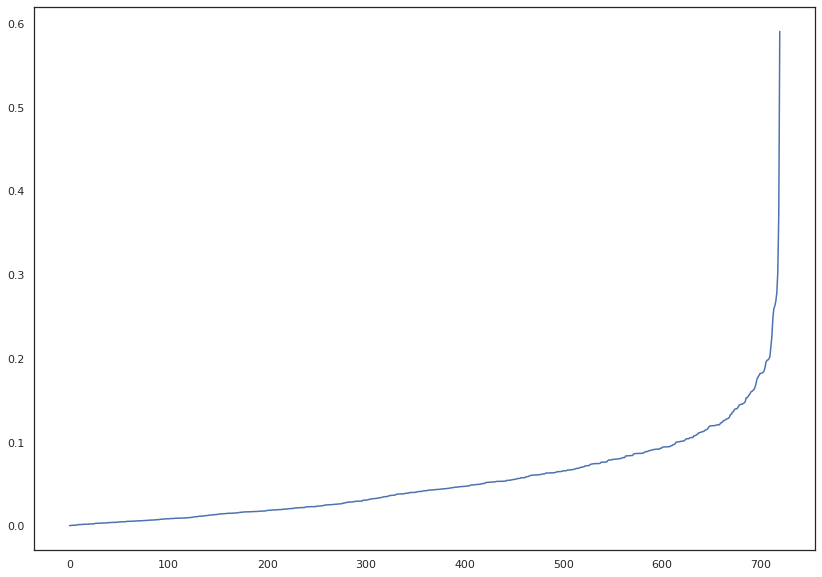

In [11]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

## Clusters

In [12]:
clusters = DBSCAN(eps=1,min_samples = 5).fit(umap_embeddings)

In [13]:
clusters.labels_[clusters.labels_ == -1].size
clusters.labels_[clusters.labels_ == -1].size/clusters.labels_.size
unique, counts = np.unique(clusters.labels_, return_counts=True)
lb_count = dict(zip(unique, counts))
lb_count

{0: 200, 1: 136, 2: 364, 3: 10, 4: 10}

In [14]:
print('the average counts for 4 is {}'.format(720/4))
inlier = clusters.labels_[clusters.labels_ != -1]
all_labels = clusters.labels_

unique, counts = np.unique(all_labels, return_counts=True)
lb_count = dict(zip(unique, counts))
print('the label with counts in dict: {}'.format(lb_count))
print('max counts label {}'.format(max(lb_count, key=lb_count.get)))

sorted_lb_count = dict(sorted(lb_count.items(), key=lambda item:item[1], reverse=True))
print('max counts label {} from the sorted dict'.format(list(sorted_lb_count)[0]))

sorted_lb_count, unique

the average counts for 4 is 180.0
the label with counts in dict: {0: 200, 1: 136, 2: 364, 3: 10, 4: 10}
max counts label 2
max counts label 2 from the sorted dict


({2: 364, 0: 200, 1: 136, 3: 10, 4: 10}, array([0, 1, 2, 3, 4]))

In [15]:
sum(sorted(counts, reverse=True)[4:])

10

In [16]:
def generate_clusters(feature_embeddings,
                       n_neighbors,
                       min_dist,
                       metric,
                       eps,
                       min_samples,
                       dbscan_metric,
#                        algorithm = 'auto',
                       random_state = config['random_state'],
                       n_components = config['n_components']):
     
    print('1️⃣ UMAP, n_neighbors: {}, min_dist: {}, umap_metric: {}'.format(n_neighbors, min_dist, metric))
    print('2️⃣ DBSCAN, eps: {}, min_samples: {}, dbscan_metric:{}'.format(eps, min_samples, dbscan_metric))
    
    umap_embeddings = umap.UMAP(n_neighbors = n_neighbors,
                                min_dist = min_dist,
                                n_components = n_components,
                                metric = metric,
                                random_state=random_state).fit_transform(feature_embeddings)
    clusters = DBSCAN(eps=eps,
                      min_samples = min_samples,
                      metric = dbscan_metric).fit(umap_embeddings) #algorithm = algorithm
    
    return clusters

In [17]:
inner_labels = clusters.labels_[clusters.labels_ != -1]
unique, counts = np.unique(inner_labels, return_counts=True)
len(counts) != 0 
counts = []
len(counts) if len(counts)!= 0 else 1

1

### Score

In [18]:
def score_clusters(clusters):

    cluster_labels = clusters.labels_
    total_num = len(clusters.labels_)
    
    inner_labels = clusters.labels_[clusters.labels_ != -1]
    unique, counts = np.unique(inner_labels, return_counts=True)
    label_and_count = dict(zip(unique, counts))
    inlabel_counts = len(unique)
    
    alpha = 0.8 #control the outlier numbers
    beta = 0.01  #control the cluster number dev from 180
    
    out_counts = clusters.labels_[clusters.labels_ == -1].size
    
    label_dev = abs(inlabel_counts - 4) * 100
    
    mean = total_num/4
    cluster_var = sum((counts - mean) ** 2)/(len(counts) if len(counts)!= 0 else 1)
    
#     sum(sorted(counts, reverse=True)[4:])/total_num
    cost =  out_counts + (label_dev * (1 - beta)  +  beta * cluster_var)
    
    print('3️⃣ LABLE&COUNTS: {}'.format(label_and_count))
    print('4️⃣ LOSS: out_counts: {}, label_dev: {}, cluster_var: {}, total: {}'.format(out_counts, label_dev, cluster_var, cost))
    return cluster_labels, cost

In [19]:
def objective(params, embeddings, label_lower = 3, label_upper = 5):
    
    clusters = generate_clusters(embeddings,
                                 n_neighbors = params['n_neighbors'], 
                                 min_dist = params['min_dist'], 
                                 metric = params['umap_metric'],
                                 eps = params['eps'],
                                 min_samples = params['min_samples'],
                                 dbscan_metric = params['dbscan_metric'],
#                                  algorithm = params['algorithm'],
                                 random_state = config['random_state'],
                                 n_components = config['n_components'])
    
    cluster_labels, cost = score_clusters(clusters)
    
    loss = cost
    
    return {'loss': loss, 'cluster_labels': cluster_labels, 'status': STATUS_OK}

In [20]:
def bayesian_search(features, space, label_lower, label_upper, max_evals=100):

    """
    Perform bayseian search on hyperopt hyperparameter space to minimize objective function
    """
    
    trials = Trials()
    
    fmin_objective = partial(objective,
                             embeddings=features,
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals = max_evals, 
                trials = trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"the cluster_labels: {trials.best_trial['result']['cluster_labels']}")

    best_clusters = generate_clusters(
                                      features,
                                      n_neighbors = best_params['n_neighbors'], 
                                      min_dist = best_params['min_dist'], 
                                      metric = best_params['umap_metric'],
                                      eps = best_params['eps'],
                                      min_samples = best_params['min_samples'],
                                      dbscan_metric = best_params['dbscan_metric'],
#                                       algorithm = best_params['algorithm'],
                                      random_state = config['random_state'],
                                      n_components = config['n_components'])
    

    return best_params, best_clusters, trials

In [21]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', config['n_neighbors']),
    "min_dist": hp.choice('min_dist', config['min_dist']),
    "umap_metric": hp.choice('umap_metric', config['umap_metric']),
    "eps": hp.choice('eps', config['eps']),
    "min_samples": hp.choice('min_samples',config['min_samples']),
    "dbscan_metric": hp.choice('dbscan_metric',config['dbscan_metric']),
#     "algorithm": hp.choice('algorithm',config['algorithm']),
}
label_lower = 3
label_upper = 5
max_evals = config['max_evals']

In [22]:
print('test the time-cost for the method {}'.format(config['method']))
%time best_params_use, best_clusters_use, trials_use = bayesian_search(feat, hspace, label_lower, label_upper, max_evals)

test the time-cost for the method DBSCAN
1️⃣ UMAP, n_neighbors: 20, min_dist: 0.6000000000000001, umap_metric: cosine
2️⃣ DBSCAN, eps: 0.8500000000000003, min_samples: 11, dbscan_metric:l2
3️⃣ LABLE&COUNTS: {0: 584, 1: 19, 2: 21, 3: 12, 4: 11}
4️⃣ LOSS: out_counts: 73, label_dev: 100, cluster_var: 54240.6, total: 714.406
1️⃣ UMAP, n_neighbors: 20, min_dist: 1.0, umap_metric: correlation
2️⃣ DBSCAN, eps: 0.9500000000000004, min_samples: 19, dbscan_metric:l2
3️⃣ LABLE&COUNTS: {0: 19, 1: 24, 2: 26, 3: 68, 4: 33, 5: 20, 6: 72, 7: 23, 8: 17}
4️⃣ LOSS: out_counts: 418, label_dev: 500, cluster_var: 21845.333333333332, total: 1131.4533333333334
1️⃣ UMAP, n_neighbors: 20, min_dist: 0.2, umap_metric: manhattan
2️⃣ DBSCAN, eps: 0.9000000000000004, min_samples: 23, dbscan_metric:l2
3️⃣ LABLE&COUNTS: {0: 201, 1: 29, 2: 327, 3: 26, 4: 34}
4️⃣ LOSS: out_counts: 103, label_dev: 100, cluster_var: 17976.6, total: 381.76599999999996
1️⃣ UMAP, n_neighbors: 180, min_dist: 0.0, umap_metric: manhattan
2️⃣ DB

#### setting one
**current setting eps: 0.6001000000000001, min_samples: 15, dbscan_metric:l2**

the label with counts without outlier: {0: 203, 1: 104, 2: 221, 3: 151}

the parts of the cost: out_counts: 41, label_dev: 0, cluster_var: 2206.75 in all 63.067499999999995

#### setting two

**current setting eps: 0.7001000000000001, min_samples: 26, dbscan_metric:l2**
                                                                              
the label with counts without outlier: {0: 202, 1: 145, 2: 214, 3: 159}
                                               
the parts of the cost: out_counts: 0, label_dev: 0, cluster_var: 826.5 in all 8.265

In [23]:
best_params_use['cluster_labels'] = trials_use.best_trial['result']['cluster_labels']
print(best_params_use)
sourceFile = open('best_params_{}.txt'.format(config['method']), 'w')
print(best_params_use, file = sourceFile)
sourceFile.close()

{'dbscan_metric': 'l2', 'eps': 0.7000000000000002, 'min_dist': 0.0, 'min_samples': 23, 'n_neighbors': 80, 'umap_metric': 'hellinger', 'cluster_labels': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  2,  1,
        1,  1,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,
        1,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,  0,  3,  3,  3,
        0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,
        0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2, 

In [24]:
trials_use.best_trial

{'state': 2,
 'tid': 1709,
 'spec': None,
 'result': {'loss': 13.0675,
  'cluster_labels': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
          2,  1,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  2,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  1,  1,  1,  2,  1,
          1,  1,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,
          1,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,  0,  3,  3,  3,
          0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,
          0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,

In [25]:
from PIL import Image, ImageOps

def group_cluster(filenames, labels):
    groups = {}
    for file, cluster in zip(filenames, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups
             
def view_cluster(cluster, groups, color="green", num = 50):
    plt.figure(figsize = (25,25))
    files = groups[cluster]
    if len(files) > num:
        print(f"Clipping cluster size from {len(files)} to {num}")
        files = files[:num-1]
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1)
        img = Image.open(all_df.loc[all_df['name'] == file, 'image_path'].iloc[0])
        plt.imshow(img)
        plt.axis('off')

In [26]:
viz = False
cluster_labels = best_params_use['cluster_labels']
inner_labels = cluster_labels[cluster_labels!= -1]
unique, counts = np.unique(inner_labels, return_counts=True)
if len(unique) == 4:
    viz = True

Clipping cluster size from 203 to 20


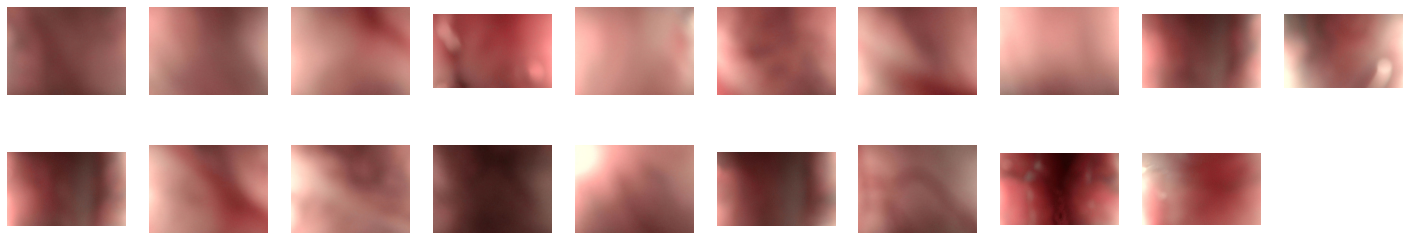

In [27]:
if viz:
    groups = group_cluster(filenames, cluster_labels)
    view_cluster(0, groups, 'green', 20)

Clipping cluster size from 140 to 20


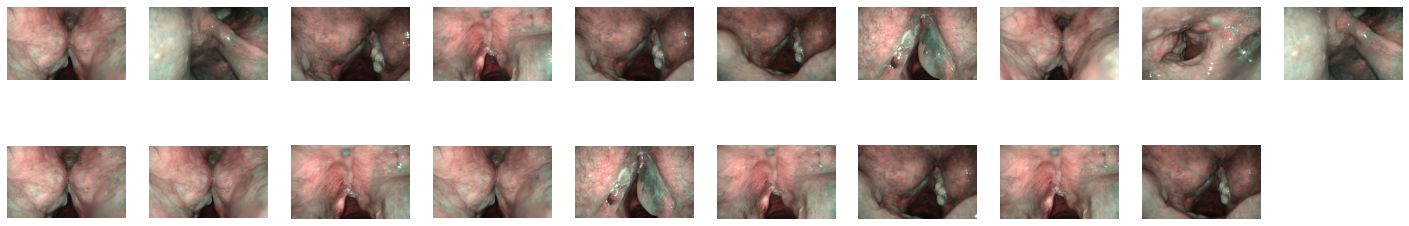

In [28]:
if viz:
    groups = group_cluster(filenames, cluster_labels)
    view_cluster(1, groups, 'yellow', 20)

Clipping cluster size from 217 to 20


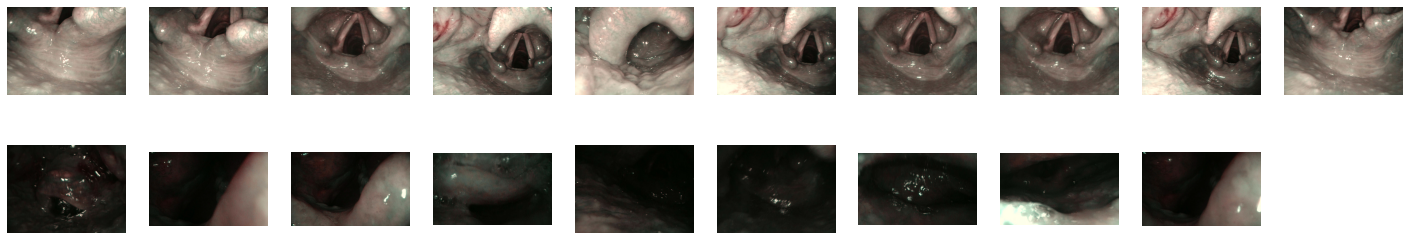

In [29]:
if viz:
    groups = group_cluster(filenames, cluster_labels)
    view_cluster(2, groups, 'blue', 20)

Clipping cluster size from 157 to 20


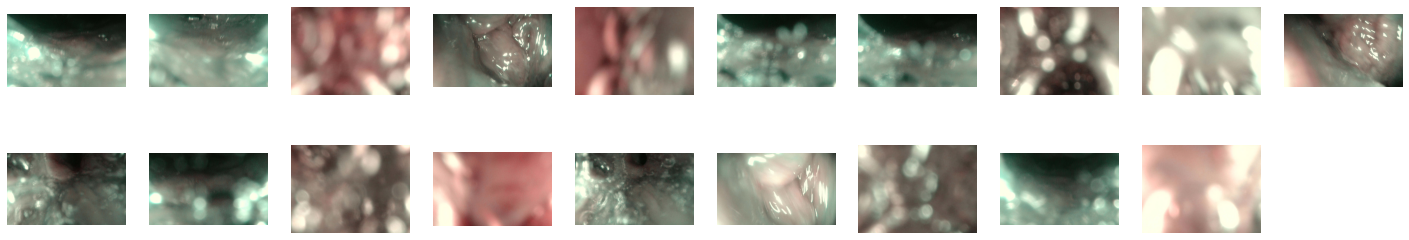

In [30]:
if viz:
    groups = group_cluster(filenames, best_params_use['cluster_labels'] )
    view_cluster(3, groups, 'purple', 20)

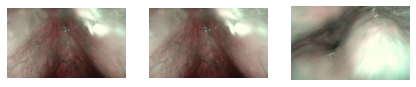

In [31]:
if cluster_labels[cluster_labels == -1].size != 0:
    groups = group_cluster(filenames, best_params_use['cluster_labels'] )
    view_cluster(-1, groups, 'red')